In [1]:
import os
from PIL import Image
import torch

from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForVision2Seq,AutoProcessor

/root/miniconda3/envs/transformers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Dataset Process
## Load captions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

captions_file = "/root/autodl-tmp/blip/c3data/tgt_train.txt"
image_dir = "/root/autodl-tmp/blip/c3data/imgs"

captions_dict = {}
with open(captions_file, 'r') as f:
    lines = f.readlines()
    for line in lines[1:10000]:
        parts = line.strip().split(',', 1)
        image_file, caption = parts[0].split(' ')[0],parts[0].split(' ')[-1]
        if image_file not in captions_dict:
            captions_dict[image_file] = caption


Using device: cuda


In [3]:
# Configuration for PEFT
#from peft import LoraConfig, TaskType, get_peft_model
#config = LoraConfig(
#    r=16,
#    lora_alpha=32,
#    lora_dropout=0.05,
#    bias="none",
#    target_modules=[
#        "self.query",
#        "self.key",
#        "self.value",
#        "output.dense",
#        "self_attn.qkv",
#        "self_attn.projection",
#        "mlp.fc1",
#        "mlp.fc2",
#    ],
#)
#
## Apply PEFT to the model
#model = get_peft_model(model, config)
#model.print_trainable_parameters()
#            
##for name, parameter in model.named_parameters():
##    print(name)

# Load model and processor
model_id = "Salesforce/blip-image-captioning-base"
#model = AutoModelForVision2Seq.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

In [5]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, captions_dict, processor):
        self.image_dir = image_dir
        self.captions_dict = captions_dict
        self.image_files = list(captions_dict.keys())
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        caption = self.captions_dict[image_file]
        # caption = captions[0]  # Using the first caption for simplicity

        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption
        return encoding

c3_caption=ImageCaptioningDataset(image_dir, captions_dict, processor)
c3_caption[0]

{'pixel_values': tensor([[[ 1.3318,  1.2588,  1.4632,  ..., -0.0113,  1.4340,  1.5362],
          [ 1.3318,  1.2734,  1.4486,  ..., -0.0259,  1.4486,  1.5362],
          [ 1.3318,  1.3026,  1.4194,  ..., -0.0405,  1.4924,  1.5216],
          ...,
          [ 1.2442,  1.2734,  1.0398,  ...,  1.3318,  1.5070,  0.3537],
          [ 1.2442,  1.2734,  1.0398,  ...,  1.3318,  1.5070,  0.3391],
          [ 1.2442,  1.2734,  1.0398,  ...,  1.3318,  1.5070,  0.3391]],
 
         [[ 1.4596,  1.3845,  1.5946,  ...,  0.0789,  1.5646,  1.6997],
          [ 1.4596,  1.3995,  1.5796,  ...,  0.0638,  1.5796,  1.6997],
          [ 1.4596,  1.4295,  1.5496,  ...,  0.0488,  1.6247,  1.6847],
          ...,
          [ 1.3695,  1.3995,  1.1594,  ...,  1.5046,  1.6547,  0.4390],
          [ 1.3695,  1.3995,  1.1594,  ...,  1.5046,  1.6547,  0.4240],
          [ 1.3695,  1.3995,  1.1594,  ...,  1.5046,  1.6547,  0.4240]],
 
         [[ 1.5629,  1.4918,  1.6909,  ...,  0.2262,  1.6340,  1.7477],
          [ 

In [6]:
c3_caption[0]['pixel_values'].shape

torch.Size([3, 384, 384])

In [7]:
## 划分数据集：

In [8]:
from torch.utils.data import random_split

trainset, validset = random_split(c3_caption, lengths=[0.9, 0.1])
len(trainset), len(validset)

(5439, 604)

In [8]:
## 创建批量加载的dataloader

In [9]:
def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [10]:
train_dataloader = DataLoader(trainset, shuffle=True, batch_size=10, collate_fn=collate_fn)
val_dataloader = DataLoader(validset, batch_size=10, collate_fn=collate_fn)

In [11]:
for key,value in next(enumerate(train_dataloader))[1].items():
    print(key)
    #print(value)

pixel_values
input_ids
attention_mask


In [13]:
# Load the fine-tuned model and processor
### 利用权重接着训练！！！！！
from transformers import AutoModelForVision2Seq,AutoProcessor

# Load model and processor
#model_id = "Salesforce/blip-image-captioning-base"
model_path = './caption_result_new/'
model = AutoModelForVision2Seq.from_pretrained(model_path)
# processor = AutoProcessor.from_pretrained(model_id)

# Setup optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0): BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): BlipEncoderLayer(
          (self_attn): BlipAttention(
 

In [23]:
# Training loop
model.train()
for epoch in range(5):  # Adjust the number of epochs as needed
    print(f"Epoch {epoch + 1}/{100}")
    epoch_loss = 0
    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=input_ids,
            attention_mask=attention_mask,)

        loss = outputs.loss
        # loss = loss  # Convert loss to torch.float32
        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss. Skipping batch.")
            continue
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")
    model.save_pretrained('./caption_result_new/')

Epoch 1/100
Average Loss for Epoch 1: 0.0095
Epoch 2/100
Average Loss for Epoch 2: 0.0093
Epoch 3/100
Average Loss for Epoch 3: 0.0085
Epoch 4/100
Average Loss for Epoch 4: 0.0071
Epoch 5/100
Average Loss for Epoch 5: 0.0050


In [24]:
# Load the fine-tuned model and processor
### 利用权重接着训练！！！！！
from transformers import AutoModelForVision2Seq,AutoProcessor

# Load model and processor
model_id = "Salesforce/blip-image-captioning-base"
model_path = './caption_result_new/'
finetuned_model = AutoModelForVision2Seq.from_pretrained(model_path)
# processor = AutoProcessor.from_pretrained(model_id)

In [25]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

def visualize_image_with_caption(image_path, caption):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

def generate_and_plot_captions(model, processor, image_dir, captions_dict, device, num_images=5):
    model.eval()
    images = list(captions_dict.keys())[:num_images]
    with torch.no_grad():
        for image_file in images:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            image.show()
            pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
            generated_output = model.generate(pixel_values=pixel_values,max_length=512)
            generated_caption = processor.batch_decode(generated_output[0], skip_special_tokens=True)
            print(generated_caption)

Generating captions with finetuned model:


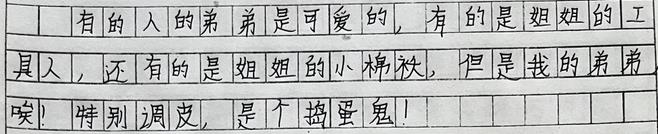

['', '他', '长', '得', '高', '高', '瘦', '瘦', '的', '，', '有', '着', '大', '眼', '睛', '，', '笑', '起', '来', '眉', '毛', '就', '变', '成', '了', '小', '月', '牙', '，', '这', '小', '月', '牙', '照', '亮', '了', '我', '美', '好', '的', '童', '年', '。', '']


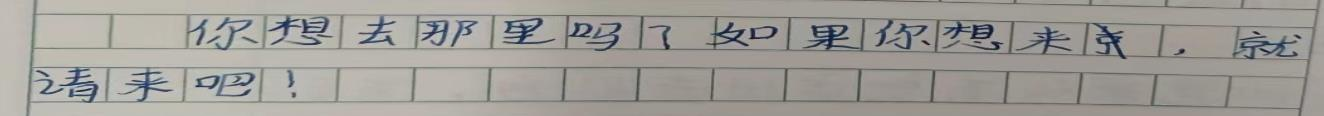

['', '你', '想', '去', '那', '里', '吗', '？', '如', '果', '你', '想', '来', 'u', '，', '就', '请', '来', '吧', '！', '']


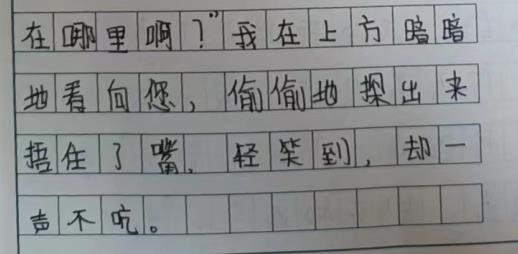

['', '祝', '：', '身', '体', '健', '康', '万', '事', '如', '意', '您', '的', '孙', '徐', '皓', '鹏', '！', '']


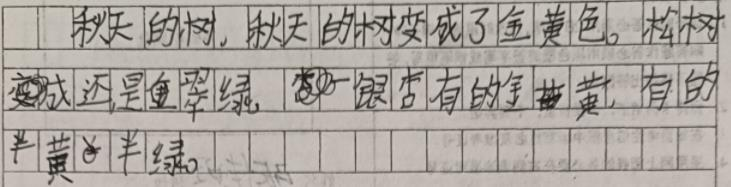

['', '秋', '天', '的', '树', '，', '秋', '天', '的', '树', '变', '成', '了', '金', '黄', '色', '。', '松', '树', 'u', '##u', '还', '是', 'u', '翠', '绿', '，', 'u', '银', '杏', '有', '的', '半', '节', '课', '，', '有', '的', '半', '黄', 'u', '半', '绿', '等', '，', '有', '的', '半', '停', '，', '还', '有', '的', '半', '黄', '色', '的', '半', '绿', '树', '和', '。', '']


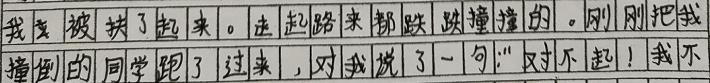

['', '我', 'u', '被', '扶', '了', '起', '来', '。', '走', '起', '路', '来', '都', '跌', '跌', '撞', '撞', '的', '。', '刚', '刚', '把', '我', '撞', '倒', '的', '同', '学', '跑', '了', '过', '来', '，', '对', '我', '说', '了', '一', '句', '：', '“', '对', '不', '起', '！', '我', '不', '']


In [27]:
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
finetuned_model.to(device)
image_dir = "/root/autodl-tmp/blip/c3data/imgs"
# Generate and plot captions after finetuning
print("Generating captions with finetuned model:")
generate_and_plot_captions(finetuned_model, processor, image_dir, captions_dict, device, num_images=5)